In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
from IPython.display import clear_output
import os
from scipy.sparse import csr_matrix, save_npz
from pandas.api.types import CategoricalDtype
import gzip
import shutil
import requests

### Part 1a - Importing and Cleaning Books Data

Data Found Here:
https://sites.google.com/eng.ucsd.edu/ucsdbookgraph/home?authuser=0

In [21]:
# Function to download genres dataset from UCSD source
def download_data(filename, new_filename):
    wd = os.getcwd()
    url = "https://datarepo.eng.ucsd.edu/mcauley_group/gdrive/goodreads/" + filename
        
    def download_by_name(fname, local_filename):

        with requests.get(url, stream=True) as r:
            r.raise_for_status()
            with open(local_filename, 'wb') as f:
                for chunk in r.iter_content(chunk_size=8192):
                    f.write(chunk)
            
    output_path = os.path.join(wd, filename)
    download_by_name(filename, output_path)

    # Unzip and convert to json
    with gzip.open(filename, 'rb') as f_in:
        with open(new_filename, 'wb') as f_out:
            shutil.copyfileobj(f_in, f_out)

In [22]:
# Read in genres table
wd = os.getcwd()
download_data("goodreads_book_genres_initial.json.gz", "genres.json")
df_genres = pd.read_json(wd + "/genres.json", lines=True)
print(df_genres.head())
print("______")
print(df_genres.info())

   book_id                                             genres
0  5333265      {'history, historical fiction, biography': 1}
1  1333909  {'fiction': 219, 'history, historical fiction,...
2  7327624  {'fantasy, paranormal': 31, 'fiction': 8, 'mys...
3  6066819  {'fiction': 555, 'romance': 23, 'mystery, thri...
4   287140                                 {'non-fiction': 3}
______
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2360655 entries, 0 to 2360654
Data columns (total 2 columns):
 #   Column   Dtype 
---  ------   ----- 
 0   book_id  int64 
 1   genres   object
dtypes: int64(1), object(1)
memory usage: 36.0+ MB
None


In [23]:
# Get counts for all distinct genres
all_genres = {}
for nt in df_genres.itertuples():
    keys = list(nt.genres.keys())
    genres = []
    for k in keys:
        split_k = str(k)
        if split_k in all_genres:
            all_genres[split_k] += 1
        else:
            all_genres[split_k] = 1
all_genres

{'history, historical fiction, biography': 663795,
 'fiction': 1244112,
 'fantasy, paranormal': 538311,
 'mystery, thriller, crime': 523156,
 'poetry': 88630,
 'romance': 658719,
 'non-fiction': 533491,
 'children': 256935,
 'young-adult': 364114,
 'comics, graphic': 171279}

In [24]:
# Extract genres into dummy variables for each book
genres = [
    "history","fiction","fantasy","mystery","poetry","romance","non_fiction","children","YA","comic","none"
    ]
dummies = []
for nt in df_genres.itertuples():
    keys = list(nt.genres.keys())   
    genre_dummies = []

    # Loop through genres
    for i in range(len(all_genres)):

        # If book is genre, add 1 for dummy
        if list(all_genres.keys())[i] in keys:
            genre_dummies.append(1)
        else:
            genre_dummies.append(0)
    
    # If no genres apply
    if sum(genre_dummies) == 0:
        genre_dummies.append(1)
    else:
        genre_dummies.append(0)

    dummies.append(genre_dummies)

# Create genre dummy columns
df_genres[genres] = dummies

In [26]:
# Read in short version of books table 
download_data("goodreads_book_works.json.gz", "goodreads_book_works.json")
df_books_short = pd.read_json(wd + "/goodreads_book_works.json", lines=True)

In [27]:
# Read in select fields from long version of books table
col_names = [
    "book_id","title","average_rating","ratings_count","publication_year","language_code","image_url","url"
    ]
json_data = []
download_data("goodreads_books.json.gz", "goodreads_books.json")
file_name = wd + "/goodreads_books.json"

with open(file_name, encoding='UTF-8') as f:
    i = 0
    for line in f:
        doc = json.loads(line)
        lst = [doc[col_names[i]] for i in range(len(col_names))]
        json_data.append(lst)
        if i % 50000 == 0:
            clear_output(wait=True)
            print(f"Processing row: {i:,d}")
        i += 1
    print(f"Completed! Processed {i:,d} rows")

df_books = pd.DataFrame(data=json_data, columns=col_names)

Processing row: 2,350,000
Completed! Processed 2,360,655 rows


In [28]:
# View df_books info
df_books.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2360655 entries, 0 to 2360654
Data columns (total 8 columns):
 #   Column            Dtype 
---  ------            ----- 
 0   book_id           object
 1   title             object
 2   average_rating    object
 3   ratings_count     object
 4   publication_year  object
 5   language_code     object
 6   image_url         object
 7   url               object
dtypes: object(8)
memory usage: 144.1+ MB


In [29]:
# Convert df_books datatypes 
df_books['book_id'] = df_books['book_id'].astype("Int64")
df_books['ratings_count'] = pd.to_numeric(df_books["ratings_count"], errors='coerce').astype('Int32')
df_books['publication_year'] = pd.to_numeric(df_books["publication_year"], errors='coerce').astype('Int32')
df_books["average_rating"] = df_books["average_rating"].replace('',"0").astype("float")

In [30]:
# Join df_genres on df_books
df_books = pd.merge(df_books, df_genres, how="left", on="book_id")

# Parse rating_dist into columns
rating_dist = []
for nt in df_books_short.itertuples():
    split = nt.rating_dist.split("|")
    dist = []
    for i in range(5):
        n = int(split[i][2:])
        dist.append(n)
    rating_dist.append(dist)

df_books_short[["5_star", "4_star", "3_star", "2_star", "1_star"]] = rating_dist

# Compute ratings avg and make smaller df_books_short
df_books_short["avg"] = df_books_short["ratings_sum"] / df_books_short["ratings_count"]
df_books_short = df_books_short[[
    "best_book_id", 
    "original_publication_year", 
    "ratings_count", 
    "avg",
    "5_star", "4_star", "3_star", "2_star", "1_star"]]
df_books_short["original_publication_year"] = pd.to_numeric(
                                                df_books_short["original_publication_year"], 
                                                errors='coerce').astype('Int32')

# Join on df_books
df_books = pd.merge(df_books, df_books_short, how="left", left_on="book_id", right_on="best_book_id")

# Populate new df_books with first non-null of each field from old df_books
years = []
ratings_counts = []
average_ratings = []
for nt in df_books.itertuples():
    
    if not isinstance(nt.publication_year, pd._libs.missing.NAType):
        years.append(nt.publication_year)
    else:
        years.append(nt.original_publication_year)
        
    if not isinstance(nt.ratings_count_x, pd._libs.missing.NAType):
        ratings_counts.append(nt.ratings_count_x)
    else:
        ratings_counts.append(nt.ratings_count_y)
    
    if not isinstance(nt.average_rating, pd._libs.missing.NAType):
        average_ratings.append(nt.average_rating)
    else:
        average_ratings.append(nt.avg)

df_books["year"] = years
df_books["ratings_count"] = ratings_counts
df_books["avg_rating"] = average_ratings

In [31]:
# Cut down to final df_books table and save to csv
df_books = df_books[[
    "book_id",
    "title",
    "avg_rating",
    "ratings_count",
    "year",
    "language_code",
    "image_url",
    "url",
    "history",
    "fiction",
    "fantasy",
    "mystery",
    "poetry",
    "romance",
    "non_fiction",
    "children",
    "YA",
    "comic",
    "none",
    "5_star",
    "4_star",
    "3_star",
    "2_star",
    "1_star",
]]

df_books["ratings_count"].fillna(0, inplace=True)
print(f"Number of books: {df_books.shape[0]}")

# Filter out books with less than 150 ratings
df_books = df_books[df_books["ratings_count"] > 150]
print(f"with > 150 ratings: {df_books.shape[0]}")

# Get rid of corrupted years
df_books["year"] = pd.to_numeric(df_books["year"], errors='coerce').astype('Int32')
df_books = df_books[df_books["year"] <= 2023]
print(f"and valid years: {df_books.shape[0]}")

# Keep only english or null language books
df_books = df_books[df_books["language_code"].isin(["","eng","en-US","en-GB","en-CA"])]
print(f"and english or null language: {df_books.shape[0]}")

# Drop duplicates on title and rating
df_books = df_books.sort_values(by="ratings_count").drop_duplicates(subset=["title", "avg_rating"])
print(f"After dropping duplicates: {df_books.shape[0]}")

# Save as csv
df_books.to_csv(wd + "/data/goodreads_books.csv", index=False)

### Part 1b - Books Data EDA

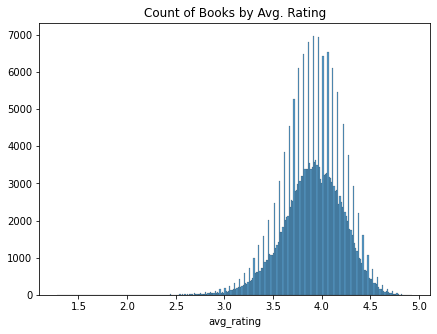

In [32]:
# Plot ratings distribution
fig, ax = plt.subplots(figsize=(7,5))
sns.histplot(
    data=df_books,
    x="avg_rating"
)
plt.title("Count of Books by Avg. Rating")
plt.ylabel(None)
plt.show()

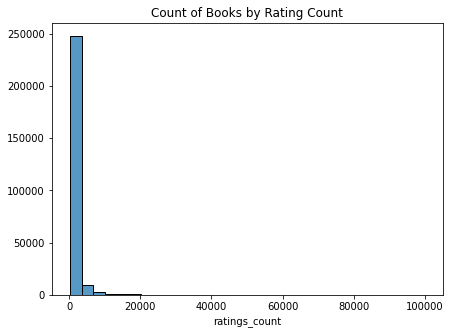

In [33]:
# Plot rating count by book
fig, ax = plt.subplots(figsize=(7,5))
sns.histplot(
    data=df_books,
    x="ratings_count",
    bins=30,
    binrange=(150, 100000)
)

plt.title("Count of Books by Rating Count")
plt.ylabel(None)
plt.show()

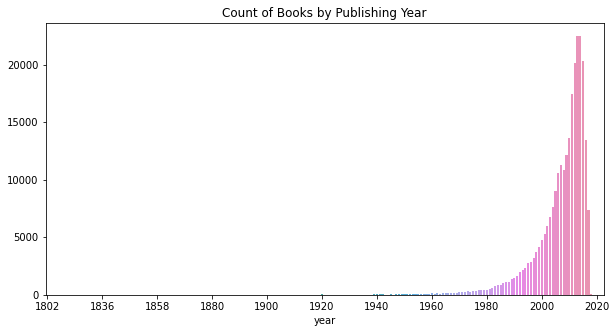

In [34]:
# Plot publishing year
fig, ax = plt.subplots(figsize=(10,5))
sns.countplot(
    data=df_books[df_books["year"] > 1800],
    x="year"
)
new_ticks = [i.get_text() for i in ax.get_xticklabels()]
plt.xticks(range(0, len(new_ticks), 20), new_ticks[::20])
plt.title("Count of Books by Publishing Year")
plt.ylabel(None)
plt.show()

/opt/anaconda3/lib/python3.9/site-packages/seaborn/categorical.py:82: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]


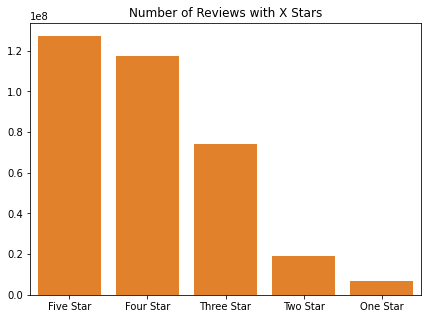

In [35]:
# Plot number of reviews by star count
five, four, three = df_books["5_star"].sum(), df_books["4_star"].sum(), df_books["3_star"].sum()
two, one = df_books["2_star"].sum(), df_books["1_star"].sum()

star_counts = pd.DataFrame([five, four, three, two, one]).T\
                .rename(columns={0:"Five Star", 1:"Four Star", 2:"Three Star", 3:"Two Star", 4:"One Star"})
fig, ax = plt.subplots(figsize=(7,5))
sns.barplot(
    data=star_counts,
    color="tab:orange"
)
plt.title("Number of Reviews with X Stars")
plt.show()

### Part 2a - Importing and cleaning user review data

In [41]:
# Read in select fields from long version of reviews table
col_names = ["user_id","book_id","review_id","rating"]
json_data = []
download_data("goodreads_reviews_dedup.json.gz", "goodreads_reviews_dedup.json")
file_name = wd + "/goodreads_reviews_dedup.json"

with open(file_name, encoding='UTF-8') as f:
    i = 0
    for line in f:
        doc = json.loads(line)
        lst = [doc[col_names[i]] for i in range(len(col_names))]
        json_data.append(lst)
        if i % 50000 == 0:
            clear_output(wait=True)
            print(f"Processing row: {i:,d}")
        i += 1
    print(f"Completed! Processed {i:,d} rows")

df_reviews = pd.DataFrame(data=json_data, columns=col_names)

Processing row: 15,700,000
Completed! Processed 15,739,967 rows


In [42]:
# View number of reviews by user
df_reviews.groupby(["user_id"])["review_id"].count().reset_index().describe()

,review_id
count,465323.000000
mean,33.825895
std,117.415545
min,1.000000
25%,2.000000
50%,6.000000
75%,22.000000
max,21811.000000


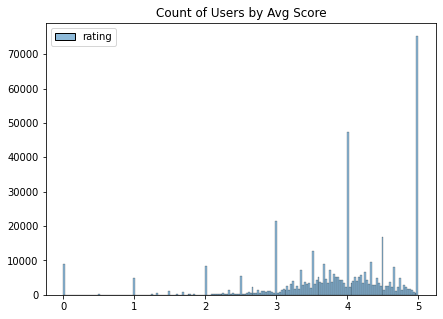

In [43]:
# View distribution of average reviews by user
fig, ax = plt.subplots(figsize=(7,5))
sns.histplot(
    data=df_reviews.groupby(["user_id"])["rating"].mean().reset_index()
    )
plt.title("Count of Users by Avg Score")
plt.ylabel(None)
plt.show()

In [44]:
# Keep only users with more than median number of reviews
user_rev_count = df_reviews.groupby(["user_id"])["review_id"].count().reset_index()
user_rev_count = user_rev_count[user_rev_count["review_id"] >= user_rev_count["review_id"].median()]
df_reviews = df_reviews[df_reviews["user_id"].isin(user_rev_count["user_id"].unique())]

In [45]:
# Pivot and convert to sparse matrix
user = CategoricalDtype(sorted(df_reviews["user_id"].unique()), ordered=True)
book = CategoricalDtype(sorted(df_reviews["book_id"].unique()), ordered=True)

row = df_reviews["user_id"].astype(user).cat.codes
col = df_reviews["book_id"].astype(book).cat.codes
sparse_reviews = csr_matrix(
        (df_reviews["rating"], (row, col)), shape=(user.categories.size, book.categories.size)
    )
sparse_reviews

<245119x2052665 sparse matrix of type '<class 'numpy.int64'>'
	with 15241069 stored elements in Compressed Sparse Row format>

In [46]:
# Get list of users and books to use as indices for sparse matrix
user_index = pd.Series(user.categories)
book_index = pd.Series(book.categories)

# Save indices as csv
user_index.to_csv(wd + "/data/user_index_for_sparse_matrix.csv", index=False)
book_index.to_csv(wd + "/data/book_index_for_sparse_matrix.csv", index=False)

In [47]:
# Save sparse matrix
save_npz(wd + "/data/goodreads_data/user_reviews.npz", sparse_reviews)

In [49]:
# Remove large raw files 
os.remove(wd + "/genres.json")
os.remove(wd + "/goodreads_book_genres_initial.json.gz")

os.remove(wd + "/goodreads_book_works.json")
os.remove(wd + "/goodreads_book_works.json.gz")

os.remove(wd + "/goodreads_books.json")
os.remove(wd + "/goodreads_books.json.gz")

os.remove(wd + "/goodreads_reviews_dedup.json")
os.remove(wd + "/goodreads_reviews_dedup.json.gz")